# Benchmark for bayesian optimization

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/00_Data_science/Notes_Gaussian_processes/test_functions.py .
!cp /content/gdrive/MyDrive/00_Data_science/Notes_Gaussian_processes/bayes_lib.py .
!pip install gpytorch
!pip install botorch
from test_functions import Hart6
from bayes_lib import ExactGPModel, train_hyper_params
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import Interval
import torch
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/gdrive
     |████████████████████████████████| 310 kB 27.0 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=c2d2b11403a1b0a98bf8083259d72cc91aeb51b4a6ca7802df4f27fcf6f9f382
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
     |████████████████████████████████| 363 kB 26.1 MB/s 
     |████████████████████████████████| 713 kB 64.6 MB/s 


In [2]:
from scipy.stats import truncnorm
def get_test_x(n, mu=0.5, sigma=0.25, lower=0.0, upper=1.0):
    """ returns a n x d tensor containing random points taking from truncated 
    normal distributions of means mu, and standard deviation sigma (mu and sigma are floats or lists of length d).
    The distribution is truncated between lower and upper bounds.
    for more information on the truncated normal distribution see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html
Parameters
==============
n: int
    number of points to return
mu: float or array-like, default: 0.5
    list of means of length d
sigma: float or array-like, default: 0.25
    list of standard deviations (must be the same length as mu)
lower: float, default: 0.0
    lower bound
uper: float, default: 1.0

Returns
==============
tensor of shape (n, d)

    """
    if type(mu) == int or type(mu) == float:
        mu = [mu]
    if type(sigma) == int or type(sigma) == float:
        sigma = [sigma]
    if len(mu) != len(sigma):
        raise ValueError(f"mu and sigma must have the same length, but got len(mu)={len(mu)}, len(sigma)={len(sigma)}")
        
    ndim = len(mu)
    out = []
    for i in range(ndim):
        X = truncnorm(
            (lower - mu[i]) / sigma[i], (upper - mu[i]) / sigma[i], loc=mu[i], scale=sigma[i])
        out.append(torch.from_numpy(X.rvs(n)))

    return torch.stack(out).T.reshape(-1,1,ndim).float()

In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.gpytorch import GPyTorchModel
from IPython.display import clear_output
class ExactGPModel(GPyTorchModel, gpytorch.models.ExactGP):
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        # super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        # self.to(train_x)
        
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
   

In [4]:
# Bayes opt loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = ExactGPModel
gt_func = Hart6(return_negative=True) # objective function
likelihood = GaussianLikelihood(noise_constraint=Interval(0.0,1e-14)).to(device)




In [ ]:
def get_x_new(EI, n_test, n_iter=1, refinement_fac = 1.1):
    """Performs the aquisition step n_iter times on n random samples taken from a normal distribution.
    At each iteration: 
      - the mean of the distribution is set to the location of the proposed point (argmax of aquisition function)
      - the standard deviation is decreased: std_new = std/(refinement_fac**j) where j is the iteration index
    This method allows for picking a good point to aquire while limiting the number of points tested
    """
    best_ei = -1e10
    mu = [0.5] * 6
    for j in range(n_iter):
        test_x = (torch.randn(int(n_test)*6).reshape(-1,1,6).float().to(device) * sigma/(refinement_fac**j))
        for ii in range(6):
            test_x[:,0,ii] += mu[ii]
        ei = EI(test_x)
        I = ei.argmax().item()
        if ei[I] > best_ei:
            best_ei = ei[I] 
            x_new = test_x[I]
    return x_new

In [49]:
train_x = torch.rand(6*20).reshape(-1,6).to(device)
train_y = gt_func.f(train_x.cpu().numpy()).to(device)
max_iter = 50
n_print = 1
it = 0
best_f = -1e5
rel_tol = 1e-06
n = int(10e6) # number of random evaluation points of the test function
# test_x = get_test_x(n, mu=[0.5 for i in range(6)],  sigma=[0.25 for i in range(6)]).to(device)
sigma = 0.25
mu = 0.5
test_x = (torch.randn(int(1e5)*6).reshape(-1,1,6).float().to(device) * sigma) + mu
error_gaps = np.zeros(max_iter)

for i in range(max_iter):
    # Run the forward model with hyperparam opt
    model = Model(train_x, train_y, likelihood).to(device)
    train_hyper_params(model, likelihood, training_iter=50)
    with torch.no_grad():
        # Run the aquisition method
        EI = ExpectedImprovement(model, best_f=0.1, maximize=True)
        
        
            # test_x = get_test_x(n, mu=x_new.reshape(-1).cpu(),  sigma=[0.125/(2**j) for i in range(6)])
            # test_x = test_x.to(device)
            # print(f"{j}, {x_new}, {ei[ei.argmax().item()]}")
            
        # Add the suggested point to the training points
    
        y_new = gt_func.f(x_new.cpu().numpy()).to(device)
        best_f = max(y_new.item(), best_f)

        train_x = torch.cat((train_x.reshape(-1,1), x_new.reshape(-1,1))).reshape(-1,6)
        train_y = torch.cat((train_y.reshape(-1,1), y_new.reshape(-1,1))).reshape(-1)
        
        if (it+1)%n_print == 0:
            print(f"{it+1}/{max_iter}: {best_f}, {train_y[-1].item()}, {np.log10(gt_func.error_gap(best_f))}")
        error_gaps[it] = gt_func.error_gap(best_f)
    it += 1

/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


1/50: 4.399345016281586e-06, 4.399345016281586e-06, 0.5214474214960362
2/50: 1.0717912118707318e-05, 1.0717912118707318e-05, 0.5214465955419525
3/50: 0.001089381636120379, 0.001089381636120379, 0.5213055711293416
4/50: 0.005079044960439205, 0.005079044960439205, 0.5207835645633662
5/50: 0.15372124314308167, 0.15372124314308167, 0.5008741005304109
6/50: 0.15372124314308167, 0.0666780024766922, 0.5008741005304109
7/50: 0.3677428066730499, 0.3677428066730499, 0.47050269059966443
8/50: 0.3677428066730499, 0.0017461354145780206, 0.47050269059966443
9/50: 0.3677428066730499, 0.005377005320042372, 0.47050269059966443
10/50: 0.3677428066730499, 0.06775175780057907, 0.47050269059966443
11/50: 0.3677428066730499, 0.003594536567106843, 0.47050269059966443
12/50: 0.3677428066730499, 0.0028463529888540506, 0.47050269059966443
13/50: 0.3677428066730499, 0.00042456237133592367, 0.47050269059966443
14/50: 0.3970412611961365, 0.3970412611961365, 0.46617467774340426
15/50: 0.3970412611961365, 0.19472599

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,


25/50: 0.3970412611961365, 0.0015897289849817753, 0.46617467774340426
26/50: 0.3970412611961365, 0.35982364416122437, 0.46617467774340426
27/50: 0.3970412611961365, 0.0019001578912138939, 0.46617467774340426
28/50: 2.0025739669799805, 2.0025739669799805, 0.12050681864642154
29/50: 2.0025739669799805, 0.4317803680896759, 0.12050681864642154
30/50: 2.0025739669799805, 0.32877665758132935, 0.12050681864642154
31/50: 2.0025739669799805, 0.5202022194862366, 0.12050681864642154
32/50: 2.0025739669799805, 0.5619476437568665, 0.12050681864642154
33/50: 2.0025739669799805, 0.0022550399880856276, 0.12050681864642154
34/50: 2.0025739669799805, 0.16622743010520935, 0.12050681864642154
35/50: 2.0025739669799805, 1.270520806312561, 0.12050681864642154
36/50: 2.0025739669799805, 0.12632960081100464, 0.12050681864642154
37/50: 2.0025739669799805, 0.21720197796821594, 0.12050681864642154
38/50: 2.0025739669799805, 1.9838416576385498, 0.12050681864642154
39/50: 2.515859365463257, 2.515859365463257, -0.0

RuntimeError: ignored

In [58]:
def baseline_model(n_iter, n):
    results = np.zeros(n_iter)
    best_result = gt_func.error_gap(gt_func.f(torch.randn((n)*6).reshape(-1,6)).max())

    for i in range(max_iter):
        best_result = min(best_result, gt_func.error_gap(gt_func.f(torch.randn(1*6).reshape(-1,6))))
        results[i] = best_result
    return results

n_bootstrap = 1
results = np.array([baseline_model(max_iter, int(1e3)) for i in range(n_bootstrap)])
mean_results = np.mean(results,0)
std_results = np.std(results,0)


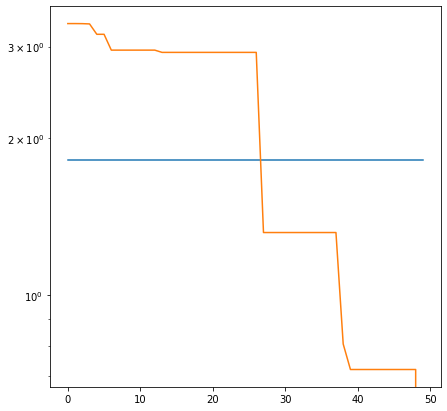

In [59]:
fig, ax = plt.subplots(1,1,figsize=[7,7])
ax.plot(mean_results)
ax.fill_between(np.arange(max_iter), 
                mean_results + 2.0*std_results, 
                mean_results - 2.0*std_results, 
                alpha=0.2)
ax.plot(error_gaps)
ax.set_yscale('log')
